In [24]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as DataUtils
import numpy as np
import time
import sys

# Readymade data loading function
DATA_ROOT='./MNISTData/'
def getMNISTDataLoaders(batchSize=64, nTrain=50000, nVal=10000, nTest=10000):
  # You can use technically use the same transform instance for all 3 sets
  assert (60000 - nVal) == nTrain, 'nTrain + nVal must be equal to 60000'
  trainTransform = transforms.Compose([transforms.ToTensor()])
  valTransform = transforms.Compose([transforms.ToTensor()])
  testTransform = transforms.Compose([transforms.ToTensor()])

  trainSet = datasets.MNIST(root=DATA_ROOT, download=True, train=True, \
                           transform=trainTransform)
  valSet = datasets.MNIST(root=DATA_ROOT, download=True, train=True, \
                         transform=valTransform)
  testSet = datasets.MNIST(root=DATA_ROOT, download=True, train=False, \
                                 transform=testTransform)

  indices = np.arange(0, 60000)
  np.random.shuffle(indices)

  trainSampler = SubsetRandomSampler(indices[:nTrain])
  valSampler = SubsetRandomSampler(indices[nTrain:])
  testSampler = SubsetRandomSampler(np.arange(0, nTest))

  trainLoader = DataUtils.DataLoader(trainSet, batch_size=batchSize, \
                                   sampler=trainSampler)
  valLoader = DataUtils.DataLoader(valSet, batch_size=batchSize, \
                                  sampler=valSampler)
  testLoader = DataUtils.DataLoader(testSet, batch_size=batchSize, \
                                    sampler=testSampler)
  return trainLoader, valLoader, testLoader

In [25]:
# Define the `device` PyTorch will be running on
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Notebook will use PyTorch Device: ' + device.upper())

Notebook will use PyTorch Device: CUDA


In [26]:
# Utility Progress Bar Function
def progress(curr, total, suffix=''):
  bar_len = 48
  filled = int(round(bar_len * curr / float(total)))
  if filled == 0:
    filled = 1
  bar = '=' * (filled - 1) + '>' + '-' * (bar_len - filled)
  sys.stdout.write('\r[%s] .. %s' % (bar, suffix))
  sys.stdout.flush()
  if curr == total:
    bar = bar_len * '='
    sys.stdout.write('\r[%s] .. %s .. Completed\n' % (bar, suffix))

In [27]:
###  Google Colab doesn't ship with advertorch and we will have to install it ourselves
# !pip install advertorch > /dev/null
# import advertorch
!pip install torchattack > /dev/null
from torchattack import PGD
import torchvision.models as models
import torch.nn as nn

# print(advertorch.__version__)

In [12]:
adv_model = models.resnet50(pretrained=False)
adv_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

adv_model.fc = nn.Linear(2048, 10)

In [13]:
n_epochs = 10
lr = 1e-2
step = 0
xent_loss = nn.CrossEntropyLoss()
adv_model = adv_model.to(device)
adv_model.train()
optimizer = torch.optim.SGD(adv_model.parameters(), lr=lr)

train_loader, val_loader, test_loader = getMNISTDataLoaders()
start_time = time.time()

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import torchvision
from torch.utils.data import Dataset, DataLoader

robust_eval_dataset = torch.load("/content/drive/My Drive/adversarial_mnist/pgd_eval_dataset.pt")
images = robust_eval_dataset["images"]      # shape: [N, C, H, W]
labels = robust_eval_dataset["labels"]      # shape: [N]

class RobustDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, lbl

robust_eval_dataset = RobustDataset(images, labels)
robust_eval_dataloader = DataLoader(robust_eval_dataset, batch_size=32, shuffle=False)


In [16]:
"""
Modified adversarial training using torchattack library.
Now trains on both original and adversarial examples for better robustness
while maintaining clean accuracy.
"""
loss_fn = nn.CrossEntropyLoss()
validation_reg_accuracy = []
validation_robust_accuracy = []
for i in range(n_epochs):
  for j, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    """
    Creating the adversary:
    -----------------------
    Adversarial examples should be generated when model parameters are frozen.
    This is essential for models with dropout or batch normalization.
    """
    adv_model.eval()  # Freeze model parameters

    """
    PGD Attack Parameters:
    - eps: perturbation budget (0.3 for MNIST in [0, 1] range)
    - steps: number of PGD iterations (7 is standard)
    - random_start: whether to start from random perturbation (more robust)
    """
    adversary = PGD(adv_model, eps=0.3, steps=7, random_start=True)
    adv_images = adversary(images, labels)  # Generate adversarial samples

    # Unfreeze model parameters for training
    adv_model.train()

    """
    Concatenate original and adversarial examples for mixed training.
    This allows the model to learn robustness while maintaining clean accuracy.
    """
    train_images = torch.cat([images, adv_images], dim=0)
    train_labels = torch.cat([labels, labels], dim=0)

    optimizer.zero_grad()
    logits = adv_model(train_images)
    loss = loss_fn(logits, train_labels)

    loss.backward()
    optimizer.step()

    if j % 8 == 0:
      progress(j+1, len(train_loader), 'Batch [{}/{}] Epoch [{}/{}] Loss = {:.3f}'.format(j+1, len(train_loader), i+1, n_epochs, loss.item()))

    step += 1
  val_correct = 0
  adv_model.eval()
  for(j, (images, labels)) in enumerate(val_loader):
    images, labels = images.to(device), labels.to(device)
    logits = adv_model(images)
    _, preds = torch.max(logits, 1)
    val_correct += (preds == labels).sum().item()
    progress(j+1, len(val_loader), 'Batch [{}/{}]'.format(j+1, len(val_loader)))
  print('Validation Accuracy = {}%'.format(float(val_correct) * 100 / 10000))
  validation_reg_accuracy.append(float(val_correct) * 100 / 10000)

  val_rob_correct = 0
  adv_model.eval()
  for(j, (images, labels)) in enumerate(robust_eval_dataloader):
    images, labels = images.to(device), labels.to(device)
    logits = adv_model(images)
    _, preds = torch.max(logits, 1)
    val_rob_correct += (preds == labels).sum().item()
    progress(j+1, len(robust_eval_dataset), 'Batch [{}/{}]'.format(j+1, len(robust_eval_dataset)))
  print('Robust Validation Accuracy = {}%'.format(float(val_rob_correct) * 100 / 500))
  validation_robust_accuracy.append(float(val_rob_correct) * 100 / 500)


end_time = time.time()
print('\nTotal training steps = {}'.format(step))
print('Total time taken = {}'.format(end_time - start_time))

[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 80.21%
[=>----------------------------------------------] .. Batch [16/500]Robust Validation Accuracy = 73.2%
[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 92.45%
[=>----------------------------------------------] .. Batch [16/500]Robust Validation Accuracy = 74.2%
[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 93.68%
[=>----------------------------------------------] .. Batch [16/500]Robust Validation Accuracy = 70.4%
[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 89.37%
[=>----------------------------------------------] .. Batch [16/500]Robust Validation Accuracy = 82.8%
[================================================] .. Batch [157/157] .. Completed
Validation Accuracy = 98.09%
[=>-------------------------

In [17]:
# Evaluation code - 98.92%
correct = 0
adv_model.eval()
for j, (images, labels) in enumerate(test_loader):
  images, labels = images.to(device), labels.to(device)
  logits = adv_model(images)
  _, preds = torch.max(logits, 1)
  correct += (preds == labels).sum().item()
  progress(j+1, len(test_loader), 'Batch [{}/{}]'.format(j+1, len(test_loader)))
adv_model.train()
print('Accuracy = {}%'.format(float(correct) * 100 / 10000))

[================================================] .. Batch [157/157] .. Completed
Accuracy = 98.64%


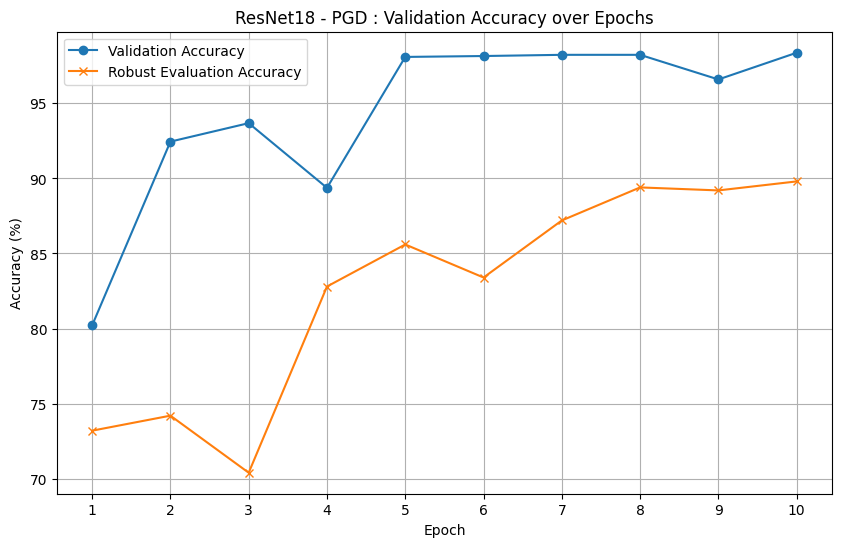

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), validation_reg_accuracy, label='Validation Accuracy', marker='o')
plt.plot(range(1, n_epochs + 1), validation_robust_accuracy, label='Robust Evaluation Accuracy', marker='x')

plt.title('ResNet18 - PGD : Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.xticks(range(1, n_epochs + 1))
save_path = "/content/drive/My Drive/adversarial_mnist/resnet50_robust_new_trained.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")

In [19]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create directories in Google Drive
os.makedirs('/content/drive/My Drive/adversarial_mnist/saved_models', exist_ok=True)
os.makedirs('/content/drive/My Drive/adversarial_mnist/adversarial_examples', exist_ok=True)

# Save the adversarially trained model
torch.save(adv_model.state_dict(), '/content/drive/My Drive/adversarial_mnist/saved_models/resnet50_adv_trained.pth')
print("Model saved to Google Drive: adversarial_mnist/saved_models/resnet50_adv_trained.pth")

print("\nGoogle Drive structure created:")
print("  My Drive/")
print("    adversarial_mnist/")
print("      saved_models/")
print("      adversarial_examples/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive: adversarial_mnist/saved_models/resnet50_adv_trained.pth

Google Drive structure created:
  My Drive/
    adversarial_mnist/
      saved_models/
      adversarial_examples/


In [31]:
import torchattack
import matplotlib.pyplot as plt

adv_model.eval()

# We'll loop through the test set until we collect 25 fooling examples
fooling_examples = []
fooling_labels = []
fooling_perturbations = []
fooled_as_labels = []
examples_found = 0
target_count = 25

for batch_idx, (images, labels) in enumerate(test_loader):
    if examples_found >= target_count:
        break

    images, labels = images.to(device), labels.to(device)

    # Generate adversarial examples
    adversary = torchattack.PGD(adv_model, eps=0.3, steps=7, random_start=True)
    adv_images = adversary(images, labels)

    # Get model predictions on adversarial examples
    with torch.no_grad():
        logits = adv_model(adv_images)
        _, preds = torch.max(logits, 1)

    # Find which ones actually fool the model (prediction != true label)
    fooled_mask = (preds != labels)

    for i in range(images.shape[0]):
        if examples_found >= target_count:
            break

        if fooled_mask[i].item():  # Only save if it fooled the model
            clean_img = images[i].cpu().detach()
            adv_img = adv_images[i].cpu().detach()
            perturbation = (adv_img - clean_img).detach()

            fooling_examples.append(adv_img)
            fooling_labels.append(labels[i].item())
            fooling_perturbations.append(perturbation)
            fooled_as_labels.append(preds[i].item())

            # Save individual examples as tensors to Google Drive
            torch.save({
                'clean': clean_img,
                'adversarial': adv_img,
                'perturbation': perturbation,
                'true_label': labels[i].item(),
                'fooled_label': preds[i].item()
            }, f'/content/drive/My Drive/adversarial_mnist/fooling_example_{examples_found}_resnet50.pth')

            # Save PNG visualizations
            fig, axes = plt.subplots(1, 3, figsize=(12, 3))

            # Clean image
            axes[0].imshow(clean_img.squeeze().numpy(), cmap='gray')
            axes[0].set_title(f'Clean\nTrue Label: {labels[i].item()}')
            axes[0].axis('off')

            # Adversarial image
            axes[1].imshow(adv_img.squeeze().numpy(), cmap='gray')
            axes[1].set_title(f'Adversarial\nFooled as: {preds[i].item()}')
            axes[1].axis('off')

            # Perturbation (amplified for visibility)
            perturbation_vis = perturbation.squeeze().abs() * 10  # Scale for visibility
            axes[2].imshow(perturbation_vis.numpy(), cmap='hot')
            axes[2].set_title(f'Perturbation\n(amplified)')
            axes[2].axis('off')

            plt.tight_layout()
            plt.savefig(f'/content/drive/My Drive/adversarial_mnist/fooling_example_{examples_found}_resnet50.png',
                        dpi=100, bbox_inches='tight')
            plt.close()

            examples_found += 1
            print(f"Found {examples_found}/25 fooling examples")

# Save all fooling examples as a single tensor file to Google Drive
torch.save({
    'adversarial_examples': torch.stack(fooling_examples),
    'true_labels': fooling_labels,
    'fooled_as_labels': fooled_as_labels,
    'perturbations': torch.stack(fooling_perturbations)
}, '/content/drive/My Drive/adversarial_mnist/all_fooling_examples_resnet50.pth')

print(f"\nTotal fooling examples found: {examples_found}")
print("All files saved to Google Drive: My Drive/adversarial_mnist/")
print("\nFiles created:")
print("  - fooling_example_X.pth (tensor data)")
print("  - fooling_example_X.png (visualization)")
print("  - all_fooling_examples.pth (all examples combined)")

Found 1/25 fooling examples
Found 2/25 fooling examples
Found 3/25 fooling examples
Found 4/25 fooling examples
Found 5/25 fooling examples
Found 6/25 fooling examples
Found 7/25 fooling examples
Found 8/25 fooling examples
Found 9/25 fooling examples
Found 10/25 fooling examples
Found 11/25 fooling examples
Found 12/25 fooling examples
Found 13/25 fooling examples
Found 14/25 fooling examples
Found 15/25 fooling examples
Found 16/25 fooling examples
Found 17/25 fooling examples
Found 18/25 fooling examples
Found 19/25 fooling examples
Found 20/25 fooling examples
Found 21/25 fooling examples
Found 22/25 fooling examples
Found 23/25 fooling examples
Found 24/25 fooling examples
Found 25/25 fooling examples

Total fooling examples found: 25
All files saved to Google Drive: My Drive/adversarial_mnist/

Files created:
  - fooling_example_X.pth (tensor data)
  - fooling_example_X.png (visualization)
  - all_fooling_examples.pth (all examples combined)
